In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [6]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures["1990-01-01":]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

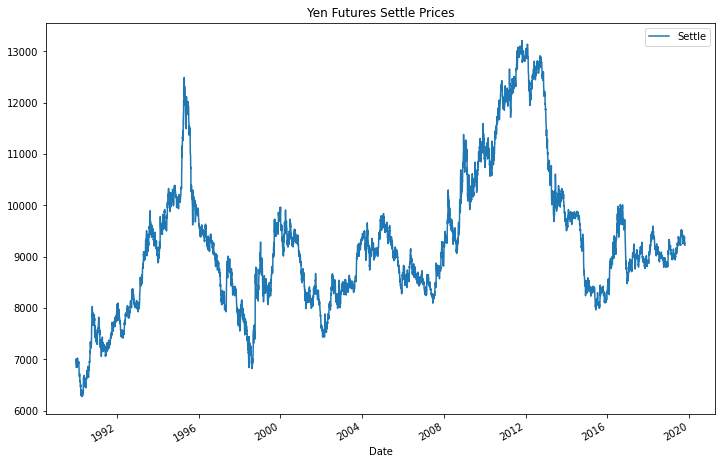

In [7]:
# Plot just the "Settle" column from the dataframe:
settle_prices_df = yen_futures[['Settle']]
settle_prices_df.plot(figsize=[12,8], title='Yen Futures Settle Prices');

In [8]:
settle_prices_df.head()

,Settle
Date,
1990-01-02,6847.0
1990-01-03,6887.0
1990-01-04,7008.0
1990-01-05,6950.0
1990-01-08,6959.0


---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [9]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(settle_prices_df["Settle"])

In [11]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
settle_decomp_df = yen_futures[['Settle']].copy()
settle_decomp_df['noise'] = settle_noise
settle_decomp_df['trend'] = settle_trend
settle_decomp_df.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


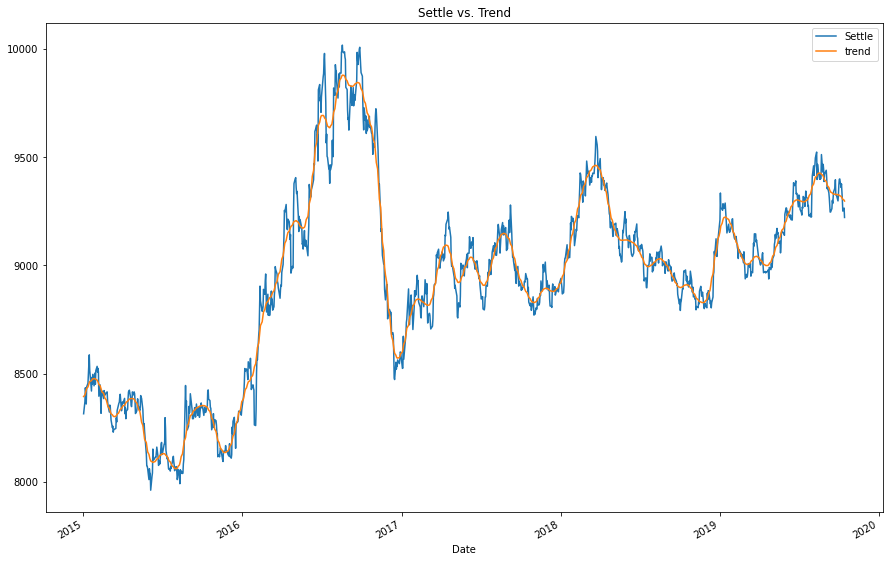

In [12]:
# Plot the Settle Price vs. the Trend for 2015 to the present
settle_v_trend_df = settle_decomp_df[["Settle", "trend"]]["2015-01-01":]
settle_v_trend_df.plot(figsize=(15, 10), title="Settle vs. Trend");

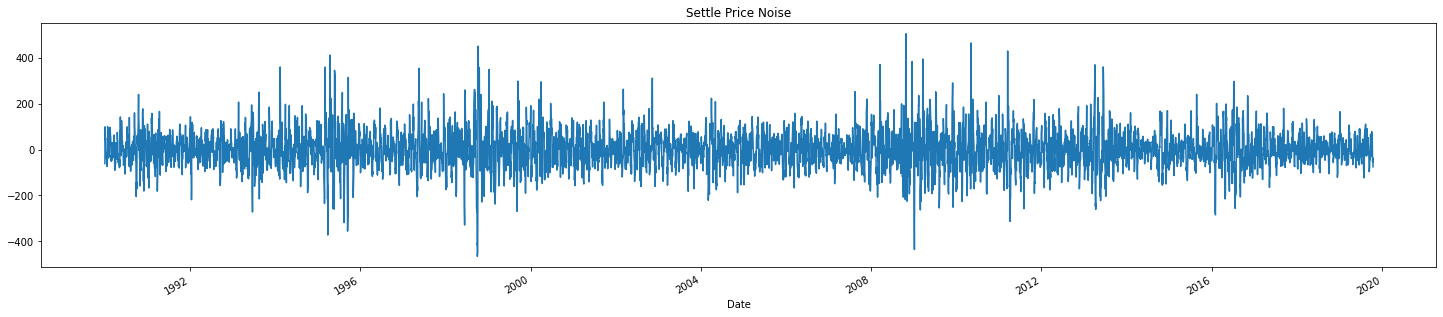

In [15]:
settle_noise.plot(figsize=(25, 5), title="Settle Price Noise");

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [31]:
pd.set_option('display.max_rows', None)

In [33]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# ???? - Where are the
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns.head()

,Settle
Date,
1990-01-02,NaN
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496


In [34]:
returns.replace([np.inf, -np.inf], np.nan, inplace=True)
returns = returns.dropna()
returns.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


In [36]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
arma_model = sm.tsa.ARMA(returns, order=(2, 1))
# arma_model

# Fit the model and assign it to a variable called results
return_results = arma_model.fit()

/Users/alexanderkelso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/alexanderkelso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been pr

In [43]:
# Output model summary results:
print(return_results.summary())

                              ARMA Model Results                              
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 29 Apr 2021   AIC                          15798.142
Time:                        13:53:16   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.09

As the P Values (P.|z|) are all not statisftically signficant (<0.05), this model isnt very reliable for makin predictions

y = 0.0063 - 0.3062 X L1 - 0.0019 X L2 + 0.2947 X MA

<bound method LikelihoodModelResults.f_test of <statsmodels.tsa.arima_model.ARMAResults object at 0x7ff659878580>>

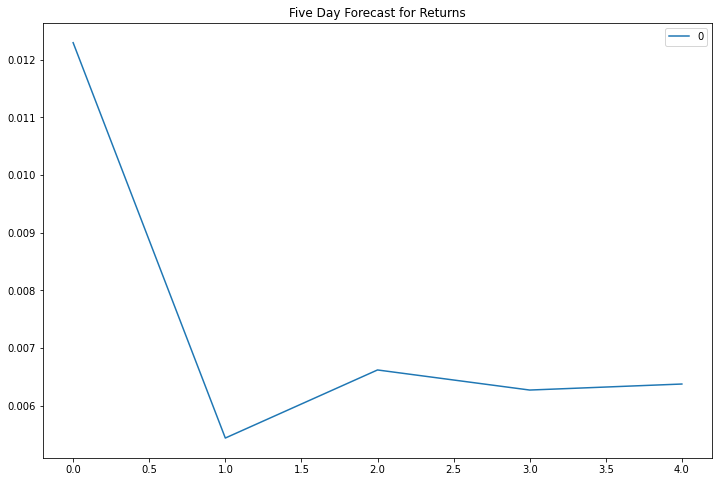

In [44]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(return_results.forecast(steps=5)[0]).plot(title="Five Day Forecast for Returns", figsize=[12,8]);

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [46]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
arima_model = ARIMA(yen_futures[["Settle"]], order=(5, 1, 1))
arima_model


/Users/alexanderkelso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/alexanderkelso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [47]:
# Fit the model
# YOUR CODE HERE!
results = arima_model.fit()

/Users/alexanderkelso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [48]:
# Output model summary results:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 29 Apr 2021   AIC                          83905.238
Time:                        13:54:28   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016

Again, all of the p values are really high. not statistically significant.


In [49]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
five_day_forecast = pd.DataFrame(results.forecast(steps=5)[0])
five_day_forecast.head()

,0
0,9224.008272
1,9225.501355
2,9226.579387
3,9227.666094
4,9228.205900


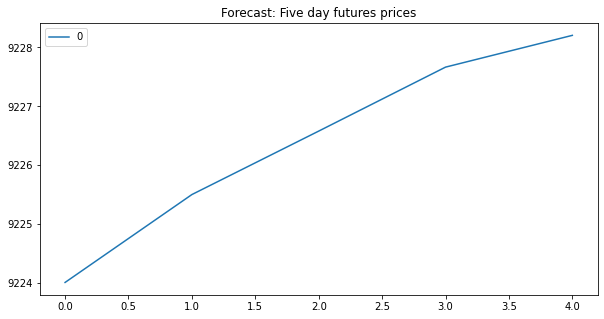

In [50]:
five_day_forecast.plot(title="Forecast: Five day futures prices", figsize=[10,5]);

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [52]:
import arch

In [53]:
# Estimate a GARCH model:
# YOUR CODE HERE!
garch_model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
# YOUR CODE HERE!
garch_results = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 87510785.45716049
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8220.92713535338
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7487.706274033166
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7505.857088437436
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.053903182994
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7895.885813879309
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7462.418448377437
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7462.214153928055
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7462.021586253446
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935968239088
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7461.927898370626
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7461.927643544426
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7461.927640079675
Iteration:     14,   Func. Count:     81,   Neg. LLF: 7461.927640

In [55]:
# Summarize the model results
# YOUR CODE HERE!
print(garch_results.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Thu, Apr 29 2021   Df Residuals:                     7514
Time:                        13:56:18   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02 

In [60]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [58]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [61]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [67]:
# Transpose the forecast so that it is easier to plot
final = intermediate.T

final.head()


Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


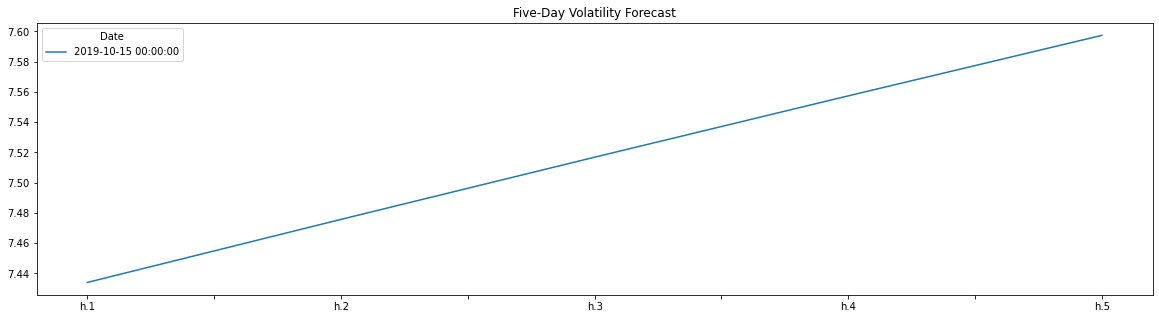

In [73]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(title="Five-Day Volatility Forecast", figsize=(20,5));

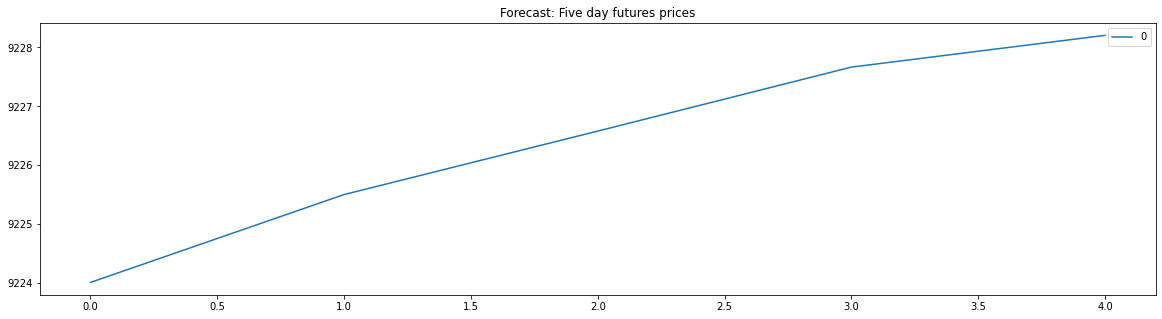

In [74]:
five_day_forecast.plot(title="Forecast: Five day futures prices", figsize=[20,5]);

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

In [ ]:
The yen price is clearly rising, so it makes sense to buy it now. It kind of comes with a risk though, because volatility is also forecast to skyrocket from 7.43 up to 7.59 by horizon level 5.

To be honest, none of the coefficients from ony pf the models boast  p values that are statistically significant (<.05). So, I wouldn't feel confident trading with them.